# Spatial Distributions of SIC and PSL

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import xarray as xr
import cftime
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4, h5netcdf, dask
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import cm, colors, colormaps
from scipy.io import loadmat

# custom package
from icepy.analysis import *

monthletters = ['J','F','M','A','M','J','J','A','S','O','N','D']
monthstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthdict = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
            7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}

# Open Datasets

In [2]:
mask_path = "../data/mask/landmask_1x1.nc"
mask = xr.open_dataset(mask_path)

In [3]:
sic_path = "../data/obs/Had2CIS/sic_1x1/had2cis_1x1_198001_202004_sicn2.nc"
psl_path = "../data/obs/ERA5/psl_1x1/psl_Amon_ERA5obs_CanESM5grid_197901-201912_1x1.nc"

# open data
sic_Had2CIS = format_time_coord(xr.open_dataset(sic_path),'1980-01','2020-04',freq='M').where(~np.isnan(mask.mask))
psl_ERA5 = format_time_coord(xr.open_dataset(psl_path),'1979-01','2019-12',freq='M')
psl_ERA5['psl'] *= 1e-2     # Convert to hectopascals 
psl_ERA5['psl'] = psl_ERA5['psl'].where(~np.isnan(mask.mask), other=np.nan)

# calculate anomalies
method = 'mean'
daterange = (1889,3019)
sic_anom_Had2CIS = remove_trend(sic_Had2CIS,'SICN',method=method,ref_period=daterange)
psl_anom_ERA5 = remove_trend(psl_ERA5,'psl',method=method,ref_period=daterange)

c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

In [4]:
sic_path = "../data/model/CanESM5/nudge/winds_195001-202112/sic_1x1/siconc_SImon_CanESM5_01_historical_r1i1p1f1_gn_195001-202112_1x1.nc"
psl_path = "../data/model/CanESM5/nudge/winds_195001-202112/psl_1x1/psl_Amon_CanESM5-rsk2052-01_historical_r1i1p1f1_gn_195001-202112_1x1.nc"

# open data
sic_CanESM5 = format_time_coord(xr.open_dataset(sic_path),'1950-01','2021-12',freq='M')
psl_CanESM5 = format_time_coord(xr.open_dataset(psl_path),'1950-01','2021-12',freq='M')
sic_CanESM5['siconc'] *= 1e-2   # decimal to percent
psl_CanESM5['psl'] *= 1e-2      # Convert to hectopascals 
psl_CanESM5['psl'] = psl_CanESM5['psl'].where(~np.isnan(mask.mask), other=np.nan)

# calculate anomalies
method = 'mean'
daterange = (1889,3019)
sic_anom_CanESM5 = remove_trend(sic_CanESM5,'siconc',method=method,ref_period=daterange)
psl_anom_CanESM5 = remove_trend(psl_CanESM5,'psl',method=method,ref_period=daterange)

c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

In [20]:
# CELL TAKES ~1-2 MINUTES TO RUN

# paths for data
data_path_list = [f"../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m{monthstr[i]}_202{int(np.heaviside(i,0))}_m{monthstr[(i+11)%12]}_ens10_sicn.nc" for i in range(12)]
grid_path = "../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_grid.nc"

# open data
sic_list = []
for i,path in enumerate(data_path_list):
    print(i, path)
    sic = format_time_coord(xr.open_dataset(path),f'1980-{monthstr[i]}',f'202{int(np.heaviside(i,0))}-{monthstr[(i+11)%12]}',freq='M')
    sic = sic.where(sic['ensemble']==9,drop=True)
    sic_list.append(sic)
grid = xr.open_dataset(grid_path)

# add a lead time coordinate
for i in range(len(sic_list)):
    im = i + 1
    sic_list[i] = sic_list[i].assign_coords(lead=(sic_list[i]['time.month'] - im)%12)

# sort by LEAD TIME and SIE, anomalies, climatology.
sic_CanESM5_init = [xr.merge([sic_list[im-1].where(sic_list[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
sic_anom_CanESM5_init = [remove_trend(sic,'SICN',method='mean',ref_period=daterange) for sic in sic_CanESM5_init]

0 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m01_2020_m12_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

1 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m02_2021_m01_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

2 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m03_2021_m02_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

3 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m04_2021_m03_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

4 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m05_2021_m04_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

5 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m06_2021_m05_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

6 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m07_2021_m06_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

7 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m08_2021_m07_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

8 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m09_2021_m08_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

9 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m10_2021_m09_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

10 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m11_2021_m10_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

11 ../data/model/CanESM5/init/sic_1x1/sf_chfp3b_1x1_1980_m12_2021_m11_ens10_sicn.nc


c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

# Plots

In [5]:
def _add_gridlines (ax,lons=[-90,0,90,180]):
    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=False,
                  linewidth=.5, color='black', alpha=1, linestyle='--',dms=True)
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = True
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator(lons)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'grey'}
    gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


def fieldplot (sicdata, psldata, psllevels=np.arange(950, 1200, 5),ccol='cyan',month=11,year=2016,title=None,regions=False):

    cmap = colors.ListedColormap(loadmat('./cmaps/cmap_jet3.mat')['cmap'], name='jet3')
    cmap.set_bad(color='lightgrey', alpha=1)  # Specify the color for NaN values
        
    # plot parameters/design
    projection = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
    transform = ccrs.PlateCarree()                                              
    domain = [-180,180,-90,-47.5]

    # data to plot
    sic = sicdata.where((sicdata['time.year']==year) & (sicdata['time.month']==month),drop=True)
    psl = psldata.where((psldata['time.year']==year) & (psldata['time.month']==month),drop=True)
    if 'siconc' in list(sicdata.variables):
        sicname = 'siconc'
    else:
        sicname = 'SICN'
    sic[sicname] = sic[sicname][list(sic[sicname].dims).index('time')]
    psl['psl'] = psl['psl'][list(psl.dims).index('time')]
    

    # plot
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(4,3),facecolor='white',dpi=200,subplot_kw={'projection':projection})
    ax.set_extent(domain,transform)
    if regions:
        _add_gridlines(ax,[20,90,160,-130,-60])
    sicplot = sic[sicname].plot(ax=ax,transform=transform,cmap=cmap,vmin=-1,vmax=1,cbar_kwargs={"label":"Sea Ice Concentration","ticks":np.arange(-1,1.2,.2)})
    pslplot = psl['psl'].plot.contour(ax=ax,transform=transform,colors=ccol,levels=psllevels,linewidths=.5)
    plt.clabel(pslplot, inline=True, fontsize=4,colors='black')
    ax.coastlines()
    if not title == None:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [9]:
# note to self: do not delete this cell
month = 11
year = 2016
title = f"{monthdict[month]} {year}"

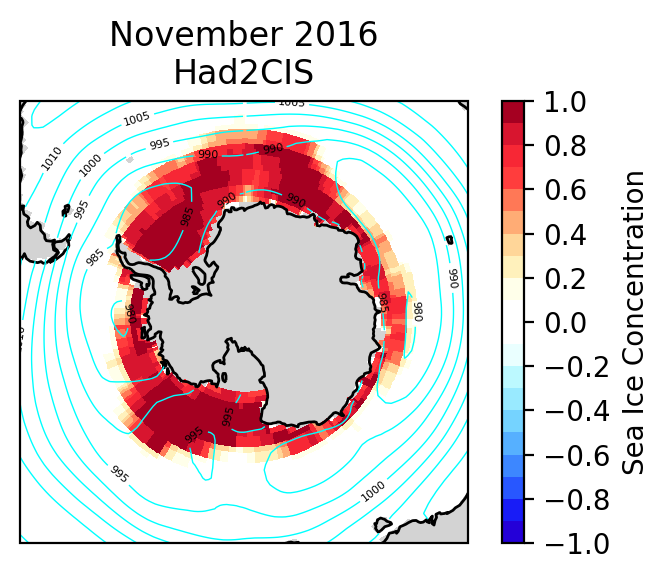

In [10]:
fieldplot(sic_Had2CIS,psl_ERA5,month=month,year=year,title=title+"\nHad2CIS")

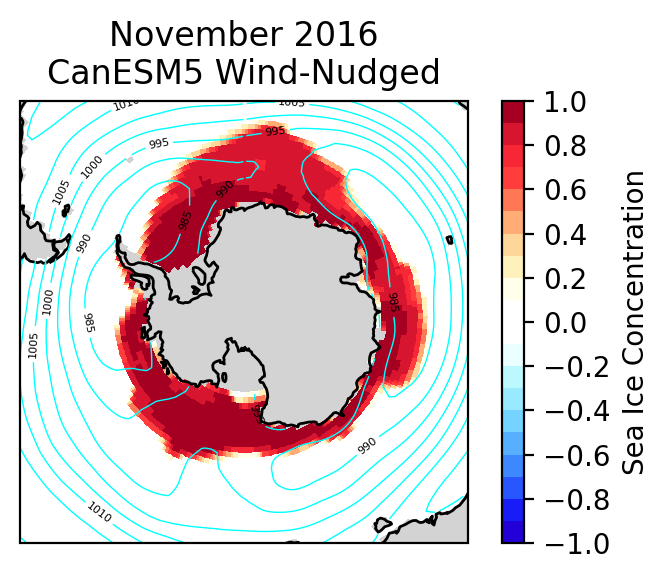

In [140]:
fieldplot(sic_CanESM5,psl_CanESM5,month=month,year=year,title=title+"\nCanESM5 Wind-Nudged")

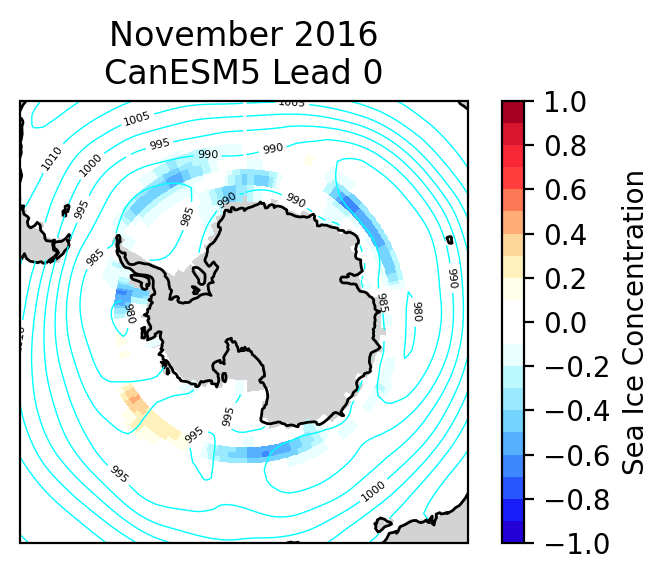

In [141]:
fieldplot(sic_anom_CanESM5_init[0],psl_ERA5,month=month,year=year,title=title+"\nCanESM5 Lead 0")

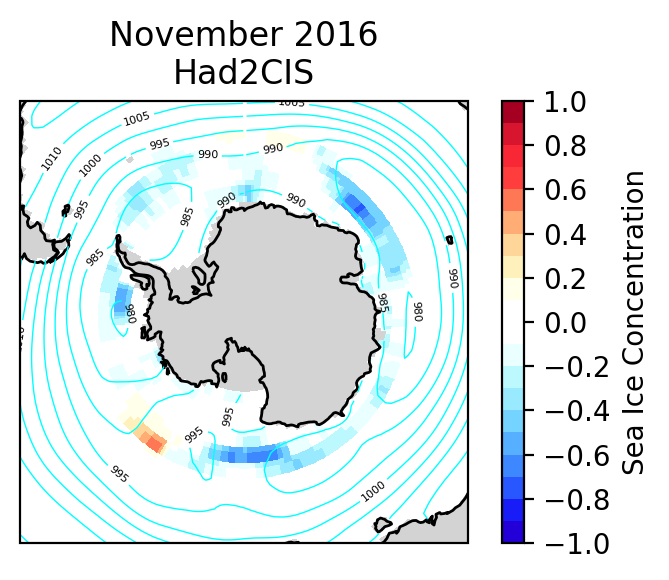

In [142]:
fieldplot(sic_anom_Had2CIS,psl_ERA5,month=month,year=year,title=title+"\nHad2CIS")

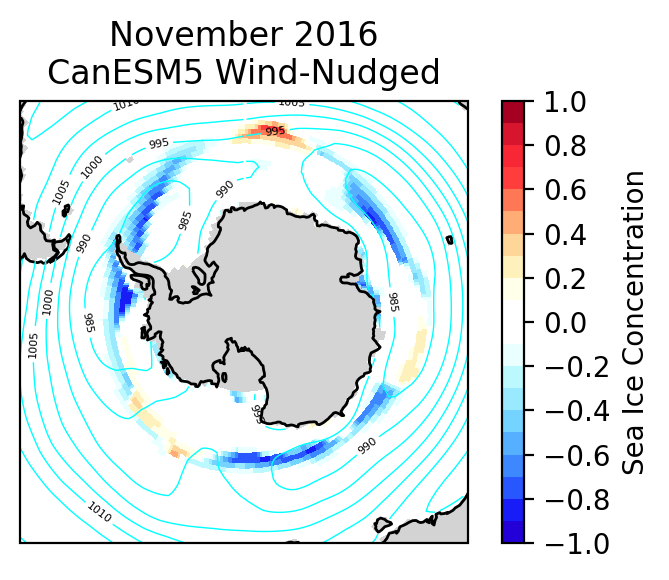

In [143]:
fieldplot(sic_anom_CanESM5,psl_CanESM5,month=month,year=year,title=title+"\nCanESM5 Wind-Nudged")

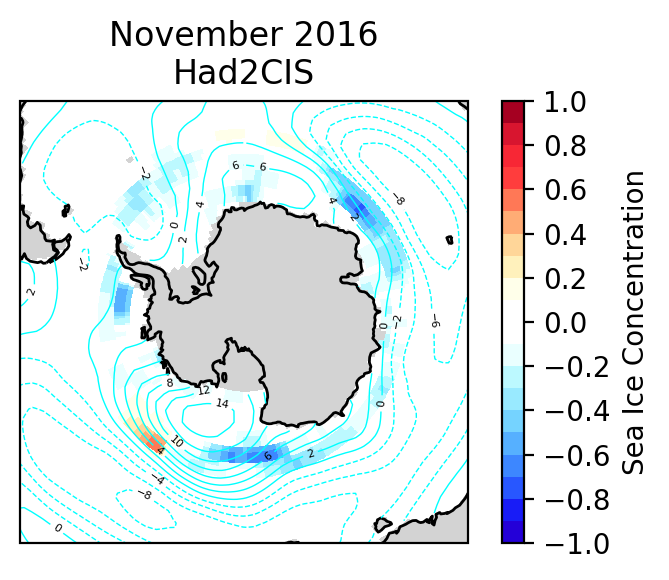

In [144]:
fieldplot(sic_anom_Had2CIS,psl_anom_ERA5,np.arange(-20,20,2),month=month,year=year,title=title+"\nHad2CIS")

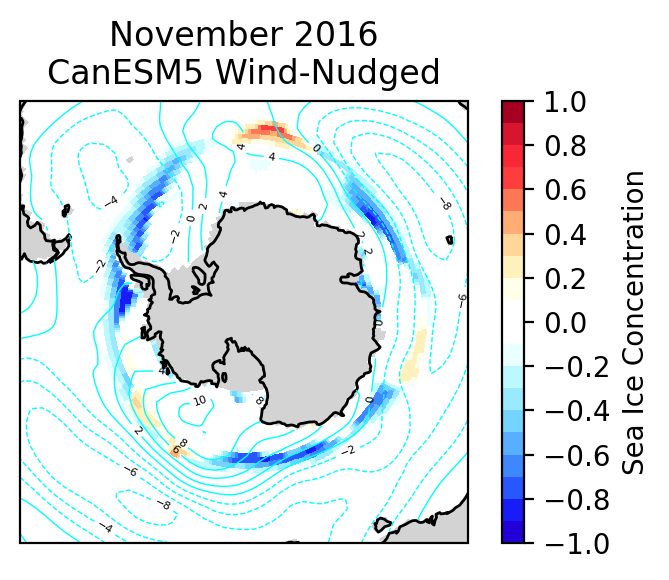

In [145]:
fieldplot(sic_anom_CanESM5,psl_anom_CanESM5,np.arange(-20,20,2),month=month,year=year,title=title+"\nCanESM5 Wind-Nudged")